In [1]:
# Import libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Activation, BatchNormalization

from keras.utils import np_utils

In [19]:
# Read in dataset
df = pd.read_csv('fer2013.csv')
# !! Work with smaller dataset to reduce runtime !!
df = df.loc[:7000]
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
6996,5,25 25 23 22 28 48 87 124 145 150 157 164 170 1...,Training
6997,3,107 36 60 100 72 48 64 92 79 19 77 43 41 14 79...,Training
6998,6,60 64 68 67 67 66 68 75 81 85 93 101 114 121 1...,Training
6999,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 6 171 ...,Training


In [20]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7001 entries, 0 to 7000
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  7001 non-null   int64 
 1   pixels   7001 non-null   object
 2   Usage    7001 non-null   object
dtypes: int64(1), object(2)
memory usage: 164.2+ KB
None


In [21]:
print('Number of instances of different emotions:')
print(df.emotion.value_counts())

Number of instances of different emotions:
3    1776
6    1192
4    1168
2    1022
0    1000
5     742
1     101
Name: emotion, dtype: int64


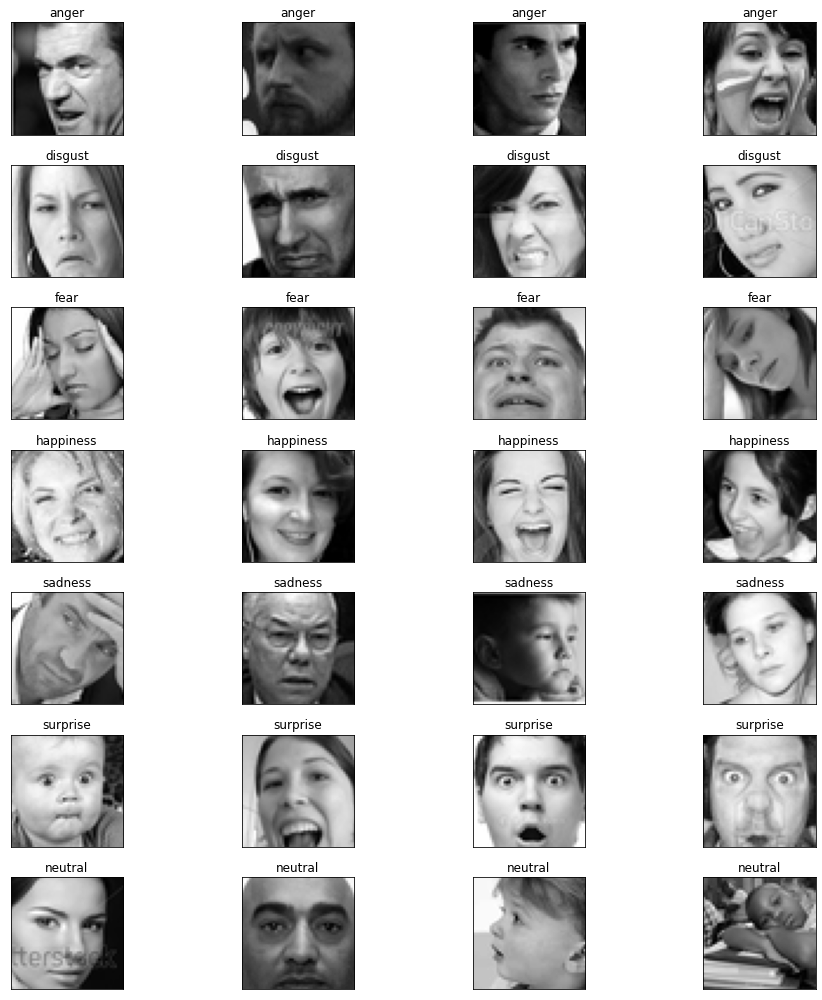

In [23]:
# Plot some image
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 
                         6: 'neutral'}

fig = plt.figure(figsize=(14, 14))

k = 0
for i in sorted(df.emotion.unique()):
    for j in range(4):
        px = df[df.emotion==i].pixels.iloc[k+50]
        px = np.array(px.split(' '))
        px = px.reshape(48, 48).astype('float32')
        k -= -1
        ax = plt.subplot(7, 4, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[i])
plt.tight_layout()

In [24]:
# Transform data
label_enc = LabelEncoder()
img_labels = label_enc.fit_transform(df['emotion'])
img_labels = np_utils.to_categorical(img_labels)

img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [25]:
# Train test split
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels, shuffle=True, test_size=0.25,
                                                      random_state=42)

print('X_train shape: {}'.format(X_train.shape))
print('X_validation shape: {}'.format(X_valid.shape))
print('------------------------------------')
print('Y_train shape: {}'.format(y_train.shape))
print('Y_validation shape: {}'.format(y_valid.shape))

X_train shape: (5250, 48, 48, 1)
X_validation shape: (1751, 48, 48, 1)
------------------------------------
Y_train shape: (5250, 7)
Y_validation shape: (1751, 7)


In [26]:
# Normalize data thus making model fitting faster
X_train = X_train / 255.
X_valid = X_valid / 255.

In [27]:
# Build the Deep CNN model
def model(optimizer):
    
    input_shape = (48,48,1)
    num_classes = y_train.shape[1]
    
    model = Sequential()
    model.add(Conv2D(128, (5, 5), input_shape=input_shape, activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (5, 5), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), activation='elu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    
    model.add(Dense(128))
    model.add(Activation('elu'))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    return model

In [28]:
# Set some optimizers to train with
optimizer_list = [
    optimizers.Adam(learning_rate=0.001),
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.RMSprop(learning_rate=0.01, epsilon=1e-07)
]

# Call the model function with different optimizers
model = model(optimizer_list[0])
# Check our model's framework
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 48, 48, 128)       3328      
_________________________________________________________________
batch_normalization_6 (Batch (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 256)       819456    
_________________________________________________________________
batch_normalization_7 (Batch (None, 24, 24, 256)       1024      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 256)      

In [29]:
# Train the model
history = model.fit(X_train, y_train, batch_size=128, epochs=25, verbose=1, workers=4, 
                    use_multiprocessing=True, validation_data=(X_valid, y_valid))

Epoch 1/25
42/42 [==============================] - 301s 7s/step - loss: 3.6444 - accuracy: 0.2065 - val_loss: 1.9835 - val_accuracy: 0.1593
Epoch 2/25
42/42 [==============================] - 288s 7s/step - loss: 1.9864 - accuracy: 0.2349 - val_loss: 1.8196 - val_accuracy: 0.2439
Epoch 3/25
42/42 [==============================] - 288s 7s/step - loss: 1.9031 - accuracy: 0.2526 - val_loss: 1.8844 - val_accuracy: 0.2530
Epoch 4/25
42/42 [==============================] - 287s 7s/step - loss: 1.9000 - accuracy: 0.2608 - val_loss: 1.9445 - val_accuracy: 0.2564
Epoch 5/25
42/42 [==============================] - 3463s 82s/step - loss: 1.8259 - accuracy: 0.2796 - val_loss: 2.0462 - val_accuracy: 0.2593
Epoch 6/25
42/42 [==============================] - 301s 7s/step - loss: 1.8018 - accuracy: 0.2977 - val_loss: 1.9706 - val_accuracy: 0.2690
Epoch 7/25
42/42 [==============================] - 290s 7s/step - loss: 1.7734 - accuracy: 0.3036 - val_loss: 2.0622 - val_accuracy: 0.2787
Epoch 8/25


In [34]:
# model.save('emotion_rec_model.h5')

In [30]:
history_df = pd.DataFrame(history.history)
history_df.index.name = 'Epochs'
history_df

,loss,accuracy,val_loss,val_accuracy
Epochs,,,,
0,3.644389,0.206476,1.983544,0.159338
1,1.986406,0.234857,1.819646,0.243861
2,1.903142,0.252571,1.884359,0.252998
3,1.899979,0.260762,1.944543,0.256425
4,1.825860,0.279619,2.046172,0.259280
5,1.801821,0.297714,1.970622,0.268989
6,1.773445,0.303619,2.062171,0.278698
7,1.735598,0.310286,1.830949,0.280411
8,1.694986,0.328381,2.264256,0.255283


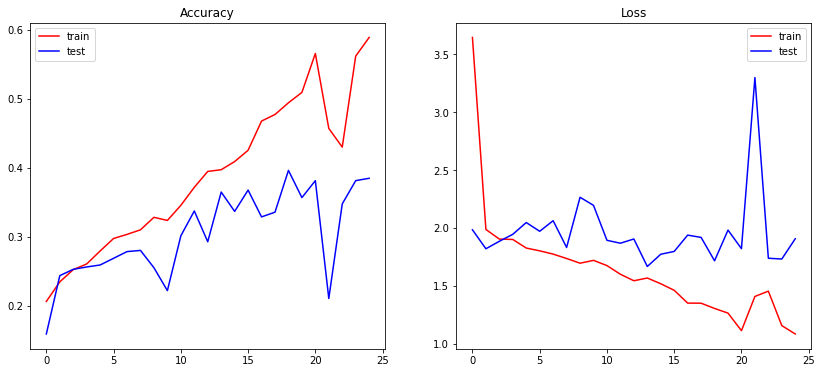

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(history.history['accuracy'], color = 'red')
axs[0].plot(history.history['val_accuracy'], color = 'blue')
axs[0].legend(['train', 'test'])
axs[0].set_title('Accuracy')

axs[1].plot(history.history['loss'], color = 'red')
axs[1].plot(history.history['val_loss'], color = 'blue')
axs[1].legend(['train', 'test'])
axs[1].set_title('Loss')

plt.show()

In [32]:
predictions = model.predict_classes(X_valid)
cm = confusion_matrix(np.argmax(y_valid, axis=1), predictions)

print('Confusion Matrix: \n\n', cm)
print('-------------------------------------')
print(classification_report(np.argmax(y_valid, axis=1), predictions))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Confusion Matrix: 

 [[ 94   0  59  37  85   1   3]
 [  3   0  10   3  10   0   0]
 [ 50   0 100  25  63   6   3]
 [ 32   0  49 274  61   2   3]
 [ 42   0  74  45 141   0   3]
 [ 19   1  89  10  29  41   1]
 [ 46   0  68  36 108   1  24]]
-------------------------------------
              precision    recall  f1-score   support

           0       0.33      0.34      0.33       279
           1       0.00      0.00      0.00        26
           2       0.22      0.40      0.29       247
           3       0.64      0.65      0.64       421
           4       0.28      0.46      0.35       305
           5       0.80      0.22      0.34       190
           6       0.65      0.08      0.15       283

    accuracy                           0.38      1751
   macro avg       0.42      0.31      0.30      1751
weighted avg       0.48      0.38      0.37      1751



Text(87.0, 0.5, 'True Label')

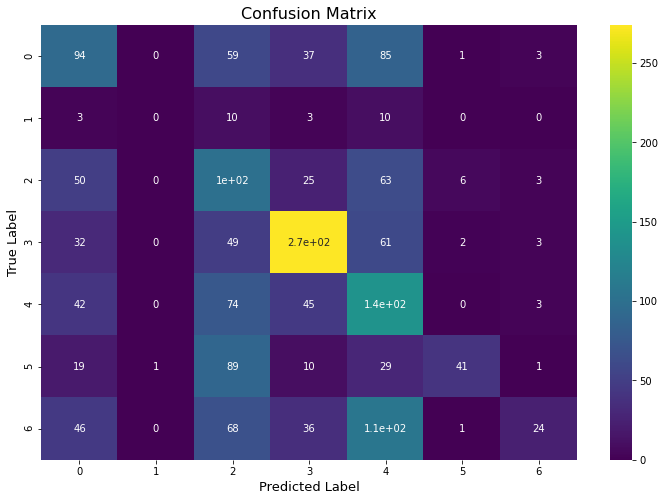

In [33]:
plt.figure(figsize=(12, 8))
sns.heatmap(cm, cmap='viridis', annot=True)
plt.title('Confusion Matrix', size=16)
plt.xlabel('Predicted Label', size=13)
plt.ylabel('True Label', size=13)